#EDA

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import pandas as pd

DATASET_DIR = "/content/drive/MyDrive/SEMESTER 7/PRAK PEM. MESIN/UAP/Soybean Seeds"

data = []

for label in os.listdir(DATASET_DIR):
    label_path = os.path.join(DATASET_DIR, label)
    if os.path.isdir(label_path):
        for img in os.listdir(label_path):
            data.append({
                "label": label,
                "filename": img
            })

df = pd.DataFrame(data)
df.head()


,label,filename
0,Broken soybeans,219.jpg
1,Broken soybeans,151.jpg
2,Broken soybeans,216.jpg
3,Broken soybeans,10.jpg
4,Broken soybeans,19.jpg


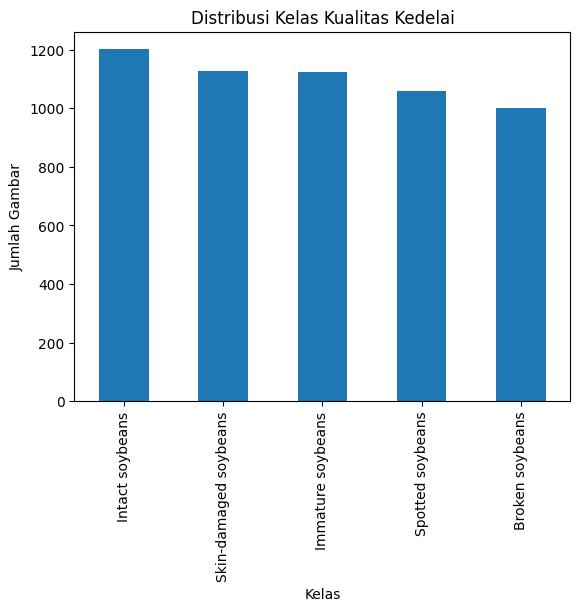

In [5]:
import matplotlib.pyplot as plt

df['label'].value_counts().plot(kind='bar')
plt.title("Distribusi Kelas Kualitas Kedelai")
plt.ylabel("Jumlah Gambar")
plt.xlabel("Kelas")
plt.show()


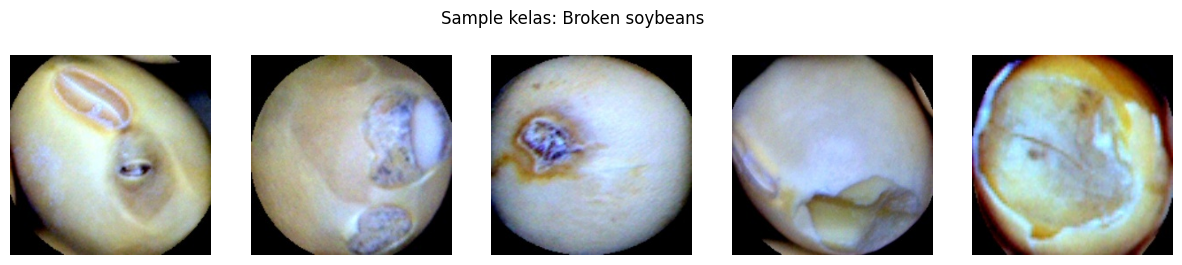

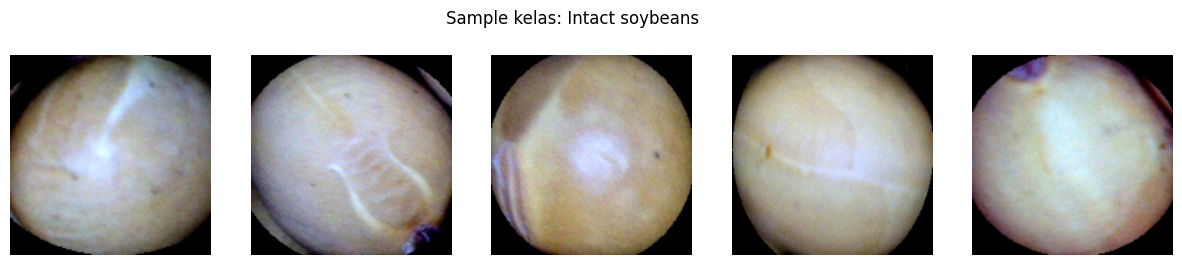

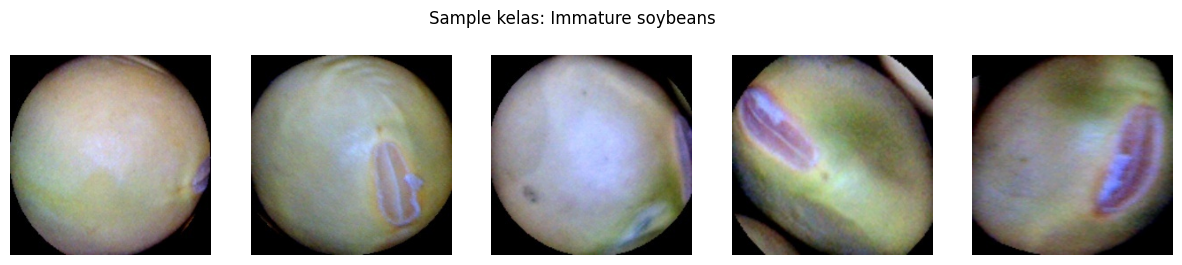

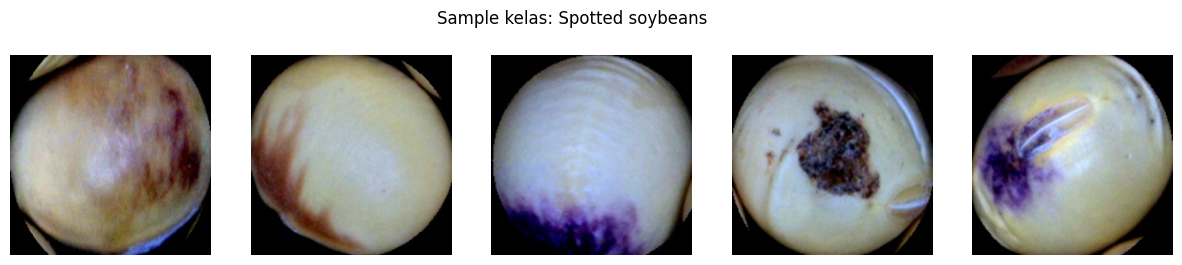

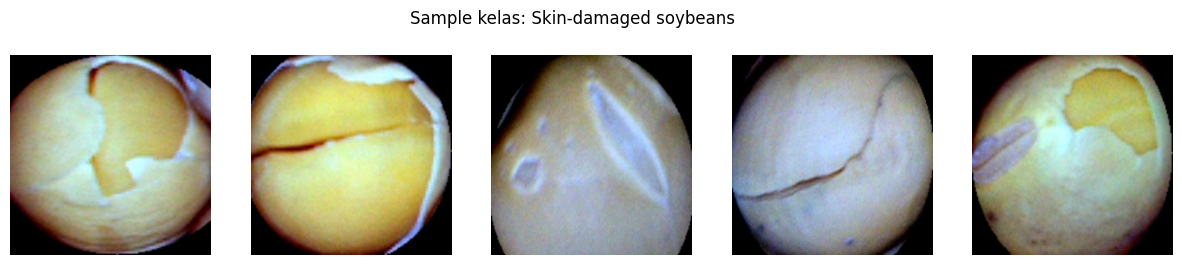

In [6]:
from PIL import Image
import matplotlib.pyplot as plt
import random

def show_samples(label, n=5):
    label_path = os.path.join(DATASET_DIR, label)
    imgs = random.sample(os.listdir(label_path), n)

    plt.figure(figsize=(15,3))
    for i, img_name in enumerate(imgs):
        img = Image.open(os.path.join(label_path, img_name))
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(f"Sample kelas: {label}")
    plt.show()

for label in df['label'].unique():
    show_samples(label)


In [ ]:
sizes = []

for _, row in df.iterrows():
    img_path = os.path.join(DATASET_DIR, row['label'], row['filename'])
    img = Image.open(img_path)
    sizes.append(img.size)  # (width, height)

sizes_df = pd.DataFrame(sizes, columns=["width", "height"])
sizes_df.describe()


#Split Data

membagi dataset citra kacang kedelai ke dalam data train, validasi, dan test dengan rasio 70:15:15 secara acak dan terstratifikasi.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os, shutil, random
from pathlib import Path
from sklearn.model_selection import train_test_split

# ====== PATH ======
RAW_DIR   = Path("/content/drive/MyDrive/SEMESTER 7/PRAK PEM. MESIN/UAP/Soybean Seeds")
OUT_DIR   = Path("/content/drive/MyDrive/SEMESTER 7/PRAK PEM. MESIN/UAP/soybean_split")

SEED = 42
random.seed(SEED)

# rasio split
TRAIN_RATIO = 0.7
VAL_RATIO   = 0.15
TEST_RATIO  = 0.15  # total harus 1.0

classes = [d.name for d in RAW_DIR.iterdir() if d.is_dir()]
classes.sort()
print("Classes:", classes)

# kumpulkan semua file + label
all_files, all_labels = [], []
for cls in classes:
    for p in (RAW_DIR/cls).rglob("*"):
        if p.suffix.lower() in [".jpg", ".jpeg", ".png", ".bmp", ".webp"]:
            all_files.append(str(p))
            all_labels.append(cls)

# split train vs temp (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    all_files, all_labels,
    test_size=(1-TRAIN_RATIO),
    random_state=SEED,
    stratify=all_labels
)

# split temp jadi val dan test (proporsional)
val_size_of_temp = VAL_RATIO / (VAL_RATIO + TEST_RATIO)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=(1-val_size_of_temp),
    random_state=SEED,
    stratify=y_temp
)

def copy_split(X, y, split_name):
    for fp, cls in zip(X, y):
        src = Path(fp)
        dst = OUT_DIR / split_name / cls / src.name
        dst.parent.mkdir(parents=True, exist_ok=True)
        if not dst.exists():
            shutil.copy2(src, dst)

# bersihin output lama (opsional)
# shutil.rmtree(OUT_DIR, ignore_errors=True)

copy_split(X_train, y_train, "train")
copy_split(X_val,   y_val,   "val")
copy_split(X_test,  y_test,  "test")

print("Done.")
print("Train:", len(X_train), "Val:", len(X_val), "Test:", len(X_test))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Classes: ['Broken soybeans', 'Immature soybeans', 'Intact soybeans', 'Skin-damaged soybeans', 'Spotted soybeans']
Done.
Train: 3859 Val: 827 Test: 827


Distribusi jumlah data pada setiap kelas

In [ ]:
from collections import Counter
print("Train dist:", Counter(y_train))
print("Val dist:", Counter(y_val))
print("Test dist:", Counter(y_test))


Train dist: Counter({'Intact soybeans': 841, 'Skin-damaged soybeans': 789, 'Immature soybeans': 787, 'Spotted soybeans': 741, 'Broken soybeans': 701})
Val dist: Counter({'Intact soybeans': 180, 'Skin-damaged soybeans': 169, 'Immature soybeans': 169, 'Spotted soybeans': 159, 'Broken soybeans': 150})
Test dist: Counter({'Intact soybeans': 180, 'Immature soybeans': 169, 'Skin-damaged soybeans': 169, 'Spotted soybeans': 158, 'Broken soybeans': 151})


#Data Preprocessing


##Load dataset (tanpa normalisasi dulu)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dataset citra kacang kedelai dimuat menggunakan fungsi image_dataset_from_directory dari TensorFlow dengan ukuran citra 224×224 dan batch size 32. Label dikodekan dalam bentuk one-hot encoding untuk klasifikasi multikelas

In [ ]:
import tensorflow as tf
from pathlib import Path

DATA_DIR = Path("/content/drive/MyDrive/SEMESTER 7/PRAK PEM. MESIN/UAP/soybean_split")
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR/"train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    label_mode="categorical",
    shuffle=True
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR/"val",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    label_mode="categorical",
    shuffle=False
)

test_ds_raw = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR/"test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    label_mode="categorical",
    shuffle=False
)

class_names = train_ds_raw.class_names
num_classes = len(class_names)
print("Classes:", class_names)
print("num_classes:", num_classes)

AUTOTUNE = tf.data.AUTOTUNE
train_ds_raw = train_ds_raw.prefetch(AUTOTUNE)
val_ds_raw   = val_ds_raw.prefetch(AUTOTUNE)
test_ds_raw  = test_ds_raw.prefetch(AUTOTUNE)


Found 3859 files belonging to 5 classes.
Found 827 files belonging to 5 classes.
Found 827 files belonging to 5 classes.
Classes: ['Broken soybeans', 'Immature soybeans', 'Intact soybeans', 'Skin-damaged soybeans', 'Spotted soybeans']
num_classes: 5


##Buat augment layer (dipakai nanti)

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.10),
])


##Buat 2 versi preprocessing (Scratch vs Pretrained)

###Untuk CNN from scratch (Rescaling 0..1):

In [ ]:
normalizer = tf.keras.layers.Rescaling(1./255)

def make_ds_for_scratch(ds, training=False):
    if training:
        ds = ds.map(lambda x, y: (normalizer(data_augmentation(x, training=True)), y),
                    num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(lambda x, y: (normalizer(x), y),
                    num_parallel_calls=AUTOTUNE)
    return ds.prefetch(AUTOTUNE)

train_scratch = make_ds_for_scratch(train_ds_raw, training=True)
val_scratch   = make_ds_for_scratch(val_ds_raw, training=False)
test_scratch  = make_ds_for_scratch(test_ds_raw, training=False)


###Cek checkpoint preprocessing (biar yakin)

In [ ]:
for x, y in train_scratch.take(1):
    print("Scratch ds batch:", x.shape, y.shape,
          "min/max:", tf.reduce_min(x).numpy(), tf.reduce_max(x).numpy())


Scratch ds batch: (32, 224, 224, 3) (32, 5) min/max: 0.0 1.0


###preprocessing untuk pretrained

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mnet_preprocess

# dataset untuk pretrained (augment hanya train, tapi normalisasi pakai preprocess_input)
def make_ds_for_pretrained(ds, preprocess_fn, training=False):
    if training:
        ds = ds.map(lambda x, y: (preprocess_fn(data_augmentation(x, training=True)), y),
                    num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(lambda x, y: (preprocess_fn(x), y),
                    num_parallel_calls=AUTOTUNE)
    return ds.prefetch(AUTOTUNE)

train_resnet = make_ds_for_pretrained(train_ds_raw, resnet_preprocess, training=True)
val_resnet   = make_ds_for_pretrained(val_ds_raw,   resnet_preprocess, training=False)
test_resnet  = make_ds_for_pretrained(test_ds_raw,  resnet_preprocess, training=False)

train_mnet = make_ds_for_pretrained(train_ds_raw, mnet_preprocess, training=True)
val_mnet   = make_ds_for_pretrained(val_ds_raw,   mnet_preprocess, training=False)
test_mnet  = make_ds_for_pretrained(test_ds_raw,  mnet_preprocess, training=False)

# quick check range (pretrained biasanya range-nya beda dari 0..1)
for x, y in train_resnet.take(1):
    print("ResNet batch min/max:", tf.reduce_min(x).numpy(), tf.reduce_max(x).numpy(), "labels:", y.shape)

for x, y in train_mnet.take(1):
    print("MobileNetV2 batch min/max:", tf.reduce_min(x).numpy(), tf.reduce_max(x).numpy(), "labels:", y.shape)


ResNet batch min/max: -123.68 151.061 labels: (32, 5)
MobileNetV2 batch min/max: -1.0 1.0 labels: (32, 5)


#CNN from scratch (Non-Pretrained)

In [ ]:
import tensorflow as tf

# ===== MODEL 1: CNN from scratch =====
def build_scratch_cnn(input_shape=(224,224,3), num_classes=5):
    inputs = tf.keras.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)
    x = tf.keras.layers.MaxPool2D()(x)

    x = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPool2D()(x)

    x = tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPool2D()(x)

    x = tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    return tf.keras.Model(inputs, outputs, name="scratch_cnn")

scratch_model = build_scratch_cnn(input_shape=(224,224,3), num_classes=num_classes)
scratch_model.summary()

scratch_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "scratch_cnn_best.keras", monitor="val_accuracy",
        save_best_only=True, mode="max", verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=5,
        restore_best_weights=True, verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5,
        patience=2, min_lr=1e-6, verbose=1
    )
]

history_scratch = scratch_model.fit(
    train_scratch,
    validation_data=val_scratch,
    epochs=25,
    callbacks=callbacks
)


Model: "scratch_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 389,701 (1.49 MB)

 Trainable params: 389,701 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2487 - loss: 1.5738
Epoch 1: val_accuracy improved from -inf to 0.36034, saving model to scratch_cnn_best.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 631s 5s/step - accuracy: 0.2491 - loss: 1.5733 - val_accuracy: 0.3603 - val_loss: 1.3578 - learning_rate: 0.0010
Epoch 2/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3624 - loss: 1.4127
Epoch 2: val_accuracy improved from 0.36034 to 0.44015, saving model to scratch_cnn_best.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 614s 5s/step - accuracy: 0.3626 - loss: 1.4124 - val_accuracy: 0.4401 - val_loss: 1.2950 - learning_rate: 0.0010
Epoch 3/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4354 - loss: 1.3216
Epoch 3: val_accuracy improved from 0.44015 to 0.59734, saving model to scratch_cnn_best.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 620s 5s/step - accuracy: 0.4356 - loss: 1.3212 - val_accuracy: 0.5973 - val_loss: 1.0738 - learning_rate: 0.0010
Epoch 4/25
121/121 ━━━━━━━━━━━━━━━━━━

26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step
=== Classification Report (Model 1 - Scratch CNN) ===
                       precision    recall  f1-score   support

      Broken soybeans       0.73      0.60      0.66       151
    Immature soybeans       0.87      0.91      0.89       169
      Intact soybeans       0.91      0.89      0.90       180
Skin-damaged soybeans       0.80      0.86      0.83       169
     Spotted soybeans       0.80      0.85      0.82       158

             accuracy                           0.83       827
            macro avg       0.82      0.82      0.82       827
         weighted avg       0.83      0.83      0.83       827

Confusion Matrix:
 [[ 90   5   2  29  25]
 [  1 154   9   0   5]
 [  1  12 161   3   3]
 [ 16   3   4 146   0]
 [ 15   4   1   4 134]]


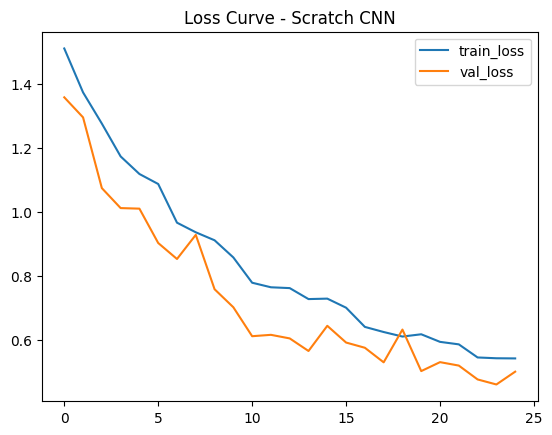

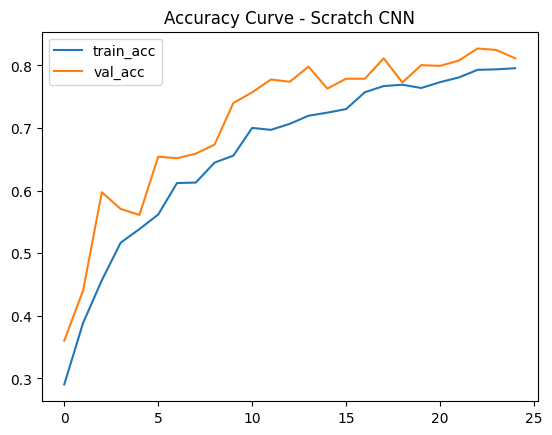

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# helper ambil y_true dari dataset one-hot
def get_true_labels(ds):
    y_true = []
    for _, y in ds:
        y_true.append(np.argmax(y.numpy(), axis=1))
    return np.concatenate(y_true)

# prediksi
y_true = get_true_labels(test_scratch)
y_prob = scratch_model.predict(test_scratch)
y_pred = np.argmax(y_prob, axis=1)

print("=== Classification Report (Model 1 - Scratch CNN) ===")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)


# plot loss & acc
plt.figure()
plt.plot(history_scratch.history["loss"], label="train_loss")
plt.plot(history_scratch.history["val_loss"], label="val_loss")
plt.title("Loss Curve - Scratch CNN")
plt.legend()
plt.show()

plt.figure()
plt.plot(history_scratch.history["accuracy"], label="train_acc")
plt.plot(history_scratch.history["val_accuracy"], label="val_acc")
plt.title("Accuracy Curve - Scratch CNN")
plt.legend()
plt.show()


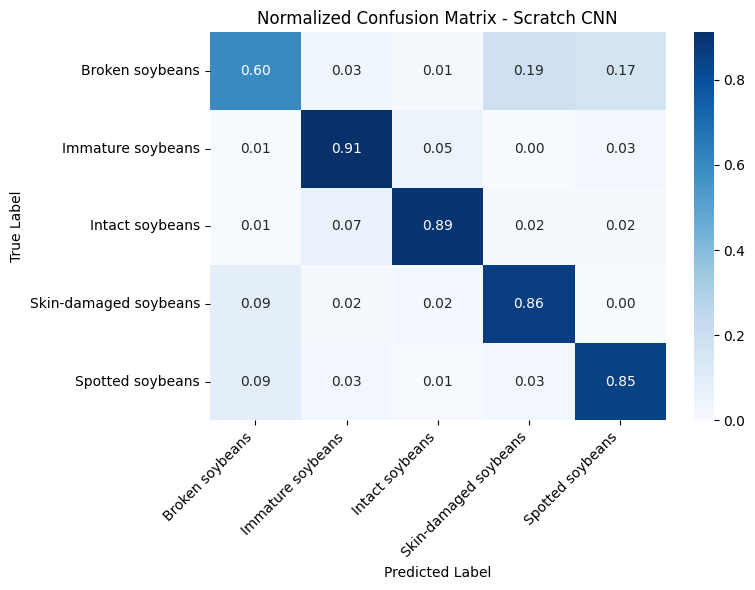

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

# Normalisasi ke persentase (per baris)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.title("Normalized Confusion Matrix - Scratch CNN")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
import os

MODEL_DIR = "/content/drive/MyDrive/SEMESTER 7/PRAK PEM. MESIN/UAP/models"
os.makedirs(MODEL_DIR, exist_ok=True)

scratch_model.save(f"{MODEL_DIR}/cnn_scratch.h5")
print("✅ Model Scratch CNN berhasil disimpan")


✅ Model Scratch CNN berhasil disimpan


In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model(f"{MODEL_DIR}/cnn_scratch.h5")
print("✅ Model berhasil diload ulang")


✅ Model berhasil diload ulang


#Resnet50


ResNet50 pretrained sebagai feature extractor yang di-freeze, lalu menambahkan classifier untuk klasifikasi 5 kelas kualitas kedelai.

In [ ]:
import tensorflow as tf

NUM_CLASSES = 5
IMG_SIZE = (224, 224)

# Base model pretrained
base = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(*IMG_SIZE, 3)
)
base.trainable = False  # tahap 1: freeze dulu

# Head classifier
inputs = tf.keras.Input(shape=(*IMG_SIZE, 3))
x = base(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

model_resnet = tf.keras.Model(inputs, outputs, name="ResNet50_TL")

model_resnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model_resnet.summary()


Model: "ResNet50_TL"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │        10,245 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,597,957 (90.02 MB)

 Trainable params: 10,245 (40.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

##Compile + callback (ResNet50)

Model dikompilasi dengan Adam optimizer dan categorical crossentropy untuk klasifikasi 5 kelas.
Callbacks digunakan untuk menghentikan training saat performa validasi stagnan, menurunkan learning rate secara adaptif, dan menyimpan model terbaik.

In [ ]:
import tensorflow as tf

# compile
model_resnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1),
    tf.keras.callbacks.ModelCheckpoint("resnet50_best.keras", monitor="val_accuracy", save_best_only=True)
]


##Train tahap 1 (head saja)

In [ ]:
EPOCHS_1 = 10  # boleh 10-15
history_resnet_1 = model_resnet.fit(
    train_resnet,
    validation_data=val_resnet,
    epochs=EPOCHS_1,
    callbacks=callbacks
)


Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 967s 8s/step - accuracy: 0.5108 - loss: 1.2464 - val_accuracy: 0.8174 - val_loss: 0.5333 - learning_rate: 0.0010
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 823s 7s/step - accuracy: 0.7710 - loss: 0.5957 - val_accuracy: 0.8380 - val_loss: 0.4493 - learning_rate: 0.0010
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 819s 7s/step - accuracy: 0.8154 - loss: 0.4983 - val_accuracy: 0.8368 - val_loss: 0.4203 - learning_rate: 0.0010
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 860s 7s/step - accuracy: 0.8403 - loss: 0.4386 - val_accuracy: 0.8585 - val_loss: 0.3710 - learning_rate: 0.0010
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 826s 7s/step - accuracy: 0.8553 - loss: 0.3810 - val_accuracy: 0.8670 - val_loss: 0.3519 - learning_rate: 0.0010
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 840s 7s/step - accuracy: 0.8661 - loss: 0.3675 - val_accuracy: 0.8755 - val_loss: 0.3358 - learning_rate: 0.0010
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 817s 7s/step - accuracy: 0.8700 - loss: 0.

##Fine-tuning (buka beberapa layer terakhir ResNet)

In [ ]:
# buka sebagian layer terakhir
base_model = model_resnet.get_layer("resnet50")
base_model.trainable = True

# freeze layer awal, unfreeze layer akhir
fine_tune_at = 140
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# compile ulang pakai LR kecil
model_resnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

EPOCHS_2 = 10
history_resnet_2 = model_resnet.fit(
    train_resnet,
    validation_data=val_resnet,
    epochs=EPOCHS_2,
    callbacks=callbacks
)


Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1268s 10s/step - accuracy: 0.7597 - loss: 0.7607 - val_accuracy: 0.8694 - val_loss: 0.4078 - learning_rate: 1.0000e-05
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1278s 10s/step - accuracy: 0.8828 - loss: 0.3358 - val_accuracy: 0.8936 - val_loss: 0.3345 - learning_rate: 1.0000e-05
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1280s 10s/step - accuracy: 0.8994 - loss: 0.2874 - val_accuracy: 0.8996 - val_loss: 0.3065 - learning_rate: 1.0000e-05
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1252s 10s/step - accuracy: 0.9150 - loss: 0.2350 - val_accuracy: 0.9045 - val_loss: 0.2982 - learning_rate: 1.0000e-05
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1260s 10s/step - accuracy: 0.9234 - loss: 0.2053 - val_accuracy: 0.9045 - val_loss: 0.2970 - learning_rate: 1.0000e-05
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1257s 10s/step - accuracy: 0.9354 - loss: 0.1880 - val_accuracy: 0.9069 - val_loss: 0.2766 - learning_rate: 1.0000e-05
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1260s 

##Evaluasi model

26/26 ━━━━━━━━━━━━━━━━━━━━ 145s 5s/step
=== Classification Report (Model 2 - ResNet50) ===
                       precision    recall  f1-score   support

      Broken soybeans       0.87      0.84      0.86       151
    Immature soybeans       0.97      0.93      0.95       169
      Intact soybeans       0.94      0.96      0.95       180
Skin-damaged soybeans       0.87      0.93      0.90       169
     Spotted soybeans       0.94      0.91      0.92       158

             accuracy                           0.92       827
            macro avg       0.92      0.91      0.91       827
         weighted avg       0.92      0.92      0.92       827



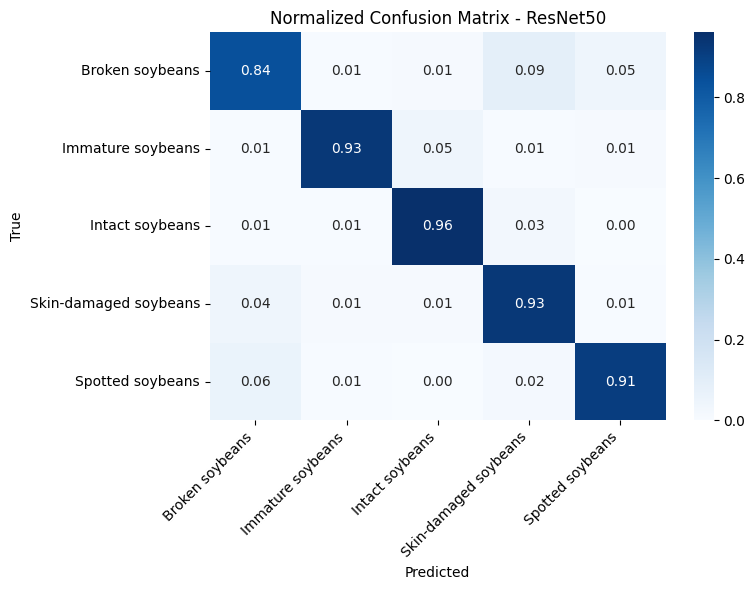

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ambil y_true
y_true = []
for _, y in test_resnet:
    y_true.append(np.argmax(y.numpy(), axis=1))
y_true = np.concatenate(y_true)

# prediksi
y_prob = model_resnet.predict(test_resnet)
y_pred = np.argmax(y_prob, axis=1)

print("=== Classification Report (Model 2 - ResNet50) ===")
print(classification_report(y_true, y_pred, target_names=class_names))

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8,6))
sns.heatmap(
    cm_norm, annot=True, fmt=".2f",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title("Normalized Confusion Matrix - ResNet50")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [ ]:
loss, accuracy = model_resnet.evaluate(test_resnet)
print(f"Test Accuracy (Overall): {accuracy:.4f}")


26/26 ━━━━━━━━━━━━━━━━━━━━ 156s 6s/step - accuracy: 0.8959 - loss: 0.3400
Test Accuracy (Overall): 0.9166


In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy(history, title):
    plt.figure(figsize=(7,5))
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_loss(history, title):
    plt.figure(figsize=(7,5))
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


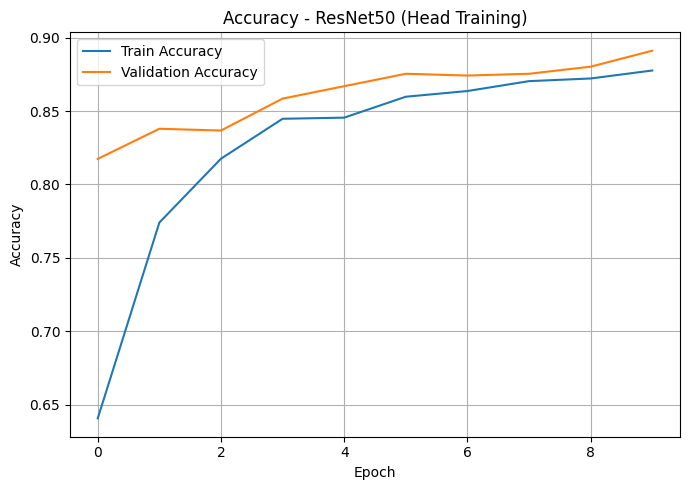

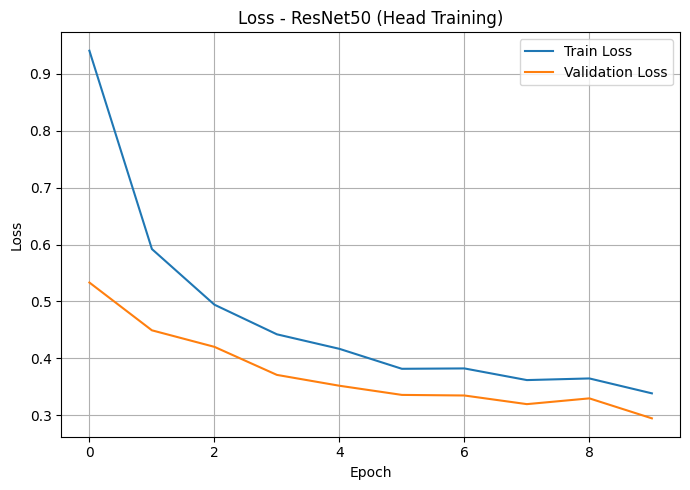

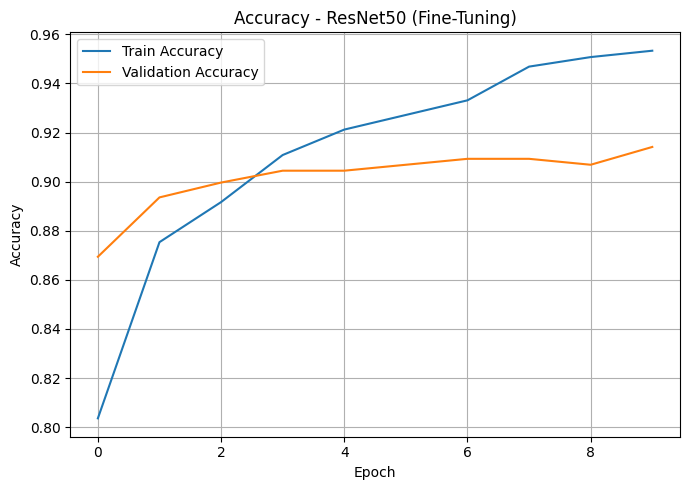

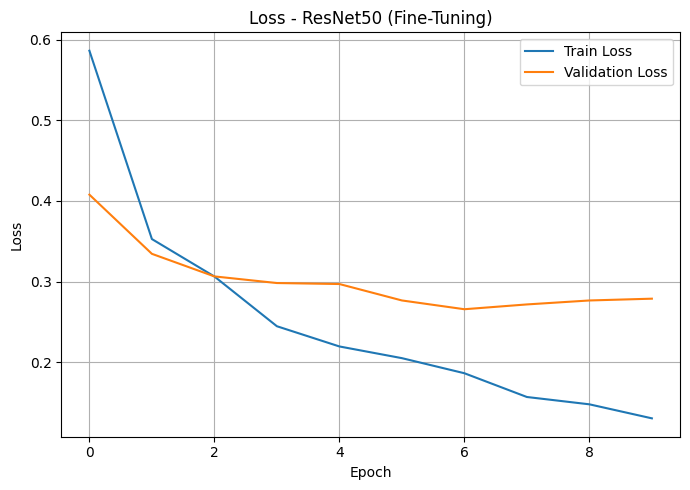

In [ ]:
# Grafik tahap 1 (head training)
plot_accuracy(history_resnet_1, "Accuracy - ResNet50 (Head Training)")
plot_loss(history_resnet_1, "Loss - ResNet50 (Head Training)")

# Grafik tahap 2 (fine-tuning)
plot_accuracy(history_resnet_2, "Accuracy - ResNet50 (Fine-Tuning)")
plot_loss(history_resnet_2, "Loss - ResNet50 (Fine-Tuning)")


In [ ]:
MODEL_DIR = "/content/drive/MyDrive/SEMESTER 7/PRAK PEM. MESIN/UAP/models"
model_resnet.save(f"{MODEL_DIR}/resnet50.h5")
print("✅ Model ResNet50 berhasil disimpan")


✅ Model ResNet50 berhasil disimpan


#MobileNetV2

In [ ]:
import tensorflow as tf

AUTOTUNE = tf.data.AUTOTUNE

mobilenet_preprocess = tf.keras.applications.mobilenet_v2.preprocess_input

def preprocess_mobilenet(x, y):
    x = tf.cast(x, tf.float32)
    x = mobilenet_preprocess(x)
    return x, y

# buat dataset MobileNetV2
train_mobilenet = train_ds_raw.map(
    preprocess_mobilenet, num_parallel_calls=AUTOTUNE
).prefetch(AUTOTUNE)

val_mobilenet = val_ds_raw.map(
    preprocess_mobilenet, num_parallel_calls=AUTOTUNE
).prefetch(AUTOTUNE)

test_mobilenet = test_ds_raw.map(
    preprocess_mobilenet, num_parallel_calls=AUTOTUNE
).prefetch(AUTOTUNE)


In [ ]:
for x, y in train_mobilenet.take(1):
    print("MobileNet batch min/max:",
          tf.reduce_min(x).numpy(),
          tf.reduce_max(x).numpy(),
          "labels:", y.shape)


MobileNet batch min/max: -1.0 1.0 labels: (32, 5)


## setup model

In [ ]:
import tensorflow as tf

base_mnet = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)
base_mnet.trainable = False  # tahap 1: freeze

inputs = tf.keras.Input(shape=(224,224,3))
x = base_mnet(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model_mobilenet = tf.keras.Model(inputs, outputs, name="MobileNetV2_TL")

model_mobilenet.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model_mobilenet.summary()


Model: "MobileNetV2_TL"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Training tahap1 (head aja)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=2, factor=0.5, verbose=1)
]

history_mnet_1 = model_mobilenet.fit(
    train_mobilenet,
    validation_data=val_mobilenet,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 216s 2s/step - accuracy: 0.4739 - loss: 1.3369 - val_accuracy: 0.7497 - val_loss: 0.6839 - learning_rate: 0.0010
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.7137 - loss: 0.7167 - val_accuracy: 0.7920 - val_loss: 0.5949 - learning_rate: 0.0010
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.7650 - loss: 0.6204 - val_accuracy: 0.8186 - val_loss: 0.5391 - learning_rate: 0.0010
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.7958 - loss: 0.5448 - val_accuracy: 0.8138 - val_loss: 0.5231 - learning_rate: 0.0010
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 216s 2s/step - accuracy: 0.8087 - loss: 0.5184 - val_accuracy: 0.8356 - val_loss: 0.4934 - learning_rate: 0.0010
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.8151 - loss: 0.4789 - val_accuracy: 0.8428 - val_loss: 0.4863 - learning_rate: 0.0010
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.8305 - loss: 0.

## fine tuning tahap 2

In [ ]:
base_mnet.trainable = True

# opsional: buka sebagian layer terakhir saja biar stabil
for layer in base_mnet.layers[:-40]:
    layer.trainable = False

model_mobilenet.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_mnet_2 = model_mobilenet.fit(
    train_mobilenet,
    validation_data=val_mobilenet,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - accuracy: 0.4536 - loss: 2.5316 - val_accuracy: 0.7582 - val_loss: 0.6508 - learning_rate: 1.0000e-05
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 279s 2s/step - accuracy: 0.7436 - loss: 0.6823 - val_accuracy: 0.7884 - val_loss: 0.5783 - learning_rate: 1.0000e-05
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.7866 - loss: 0.5305 - val_accuracy: 0.8041 - val_loss: 0.5478 - learning_rate: 1.0000e-05
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 274s 2s/step - accuracy: 0.8280 - loss: 0.4507 - val_accuracy: 0.8271 - val_loss: 0.5044 - learning_rate: 1.0000e-05
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 283s 2s/step - accuracy: 0.8416 - loss: 0.4107 - val_accuracy: 0.8259 - val_loss: 0.5067 - learning_rate: 1.0000e-05
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8661 - loss: 0.3443
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
121/121 ━━━━━━━━━━━━━━━━━━━━ 275s 2s/step - accuracy: 

In [ ]:
test_loss, test_acc = model_mobilenet.evaluate(test_mobilenet, verbose=0)
print(f"✅ MobileNetV2 Test Accuracy: {test_acc:.4f}")
print(f"✅ MobileNetV2 Test Loss: {test_loss:.4f}")


✅ MobileNetV2 Test Accuracy: 0.8041
✅ MobileNetV2 Test Loss: 0.5166


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# prediksi
y_prob = model_mobilenet.predict(test_mobilenet, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

# ambil label asli dari dataset (one-hot -> index)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in test_mobilenet], axis=0)

print("=== Classification Report (Model 3 - MobileNetV2) ===")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)


=== Classification Report (Model 3 - MobileNetV2) ===
                       precision    recall  f1-score   support

      Broken soybeans       0.85      0.75      0.80       151
    Immature soybeans       0.89      0.66      0.76       169
      Intact soybeans       0.68      0.94      0.79       180
Skin-damaged soybeans       0.88      0.79      0.83       169
     Spotted soybeans       0.82      0.87      0.84       158

             accuracy                           0.80       827
            macro avg       0.82      0.80      0.80       827
         weighted avg       0.82      0.80      0.80       827

Confusion Matrix:
 [[114   3   4  13  17]
 [  0 112  46   2   9]
 [  0   7 169   3   1]
 [  9   1  22 133   4]
 [ 11   3   6   1 137]]


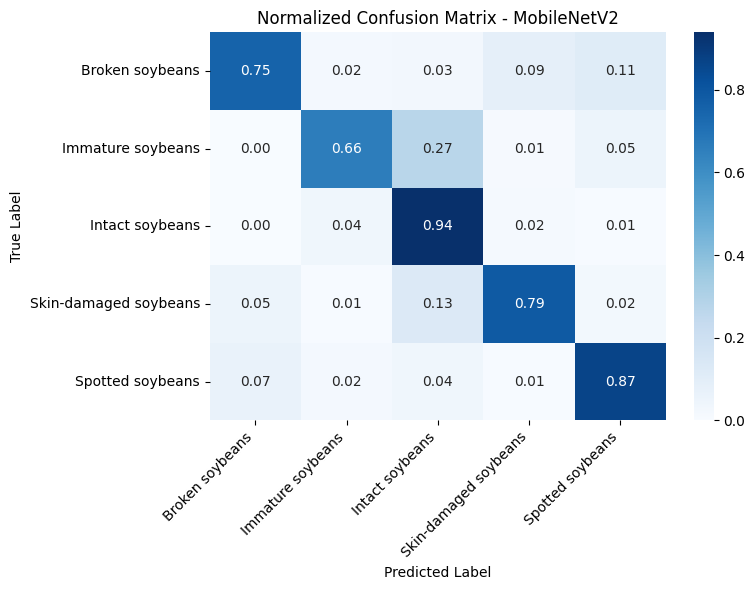

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# === Ambil y_true & y_pred ===
y_true = np.concatenate([
    np.argmax(y.numpy(), axis=1) for _, y in test_mobilenet
], axis=0)

y_prob = model_mobilenet.predict(test_mobilenet, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)

# Normalisasi per baris (per kelas)
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

# === Plot ===
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.title("Normalized Confusion Matrix - MobileNetV2")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


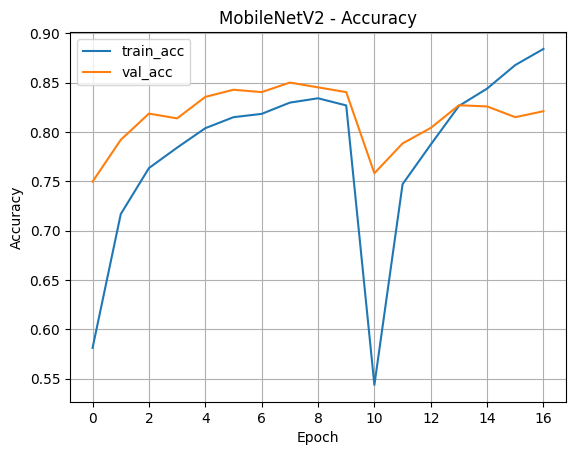

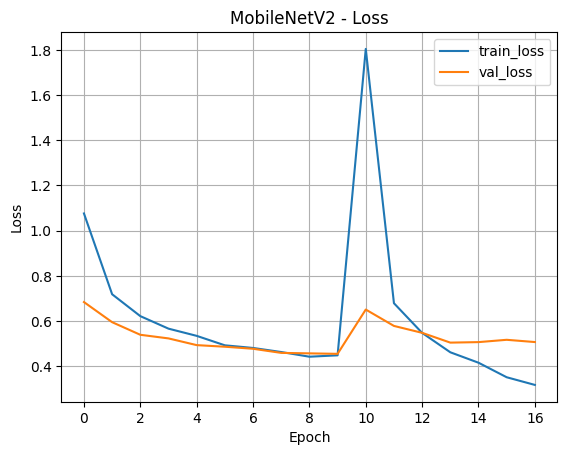

In [ ]:
import matplotlib.pyplot as plt

def merge_histories(h1, h2):
    out = {}
    for k in h1.history.keys():
        out[k] = h1.history[k] + h2.history.get(k, [])
    return out

hist = merge_histories(history_mnet_1, history_mnet_2)

# Accuracy
plt.figure()
plt.plot(hist["accuracy"], label="train_acc")
plt.plot(hist["val_accuracy"], label="val_acc")
plt.title("MobileNetV2 - Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure()
plt.plot(hist["loss"], label="train_loss")
plt.plot(hist["val_loss"], label="val_loss")
plt.title("MobileNetV2 - Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import os
MODEL_DIR = "/content/drive/MyDrive/SEMESTER 7/PRAK PEM. MESIN/UAP/models"
os.makedirs(MODEL_DIR, exist_ok=True)

model_mobilenet.save(f"{MODEL_DIR}/mobilenetv2.h5")
print("✅ Model MobileNetV2 berhasil disimpan")


✅ Model MobileNetV2 berhasil disimpan


In [ ]:
import json
with open(f"{MODEL_DIR}/class_names.json", "w") as f:
    json.dump(class_names, f)
print("✅ class_names disimpan")


✅ class_names disimpan
